In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
np.random.seed(3698)

In [6]:
class SOT:
    def __init__(self, A, B, C, d, Sw, Sv, PD, ld):
        # Motion model: x(t) = A x(t-1) + B u(t-1) + w(t-1), t=1..T
        # Motion noise: W ~ N(0, Sw)
        self.A = A
        self.B = B
        self.Sw = Sw

        # Measurement model: z(t) = C x(t) + d + v(t), t=0..T
        # Measurement noise: V ~ N(0, Sv)
        self.C = C
        self.d = d
        self.Sv = Sv

        # Shape:
        #   x, w: (n, )
        #   z, d, v: (m, )
        #   u: (p, )
        #   A: (n, n)
        #   B: (n, p)
        #   C: (m, n)
        #   Sw: (n, n)
        #   Sv: (m, m)
        self.n = A.shape[0]
        self.m = C.shape[0]

        # Probability of detection
        self.PD = PD

        # Clutter model:
        self.ld = ld

    def state_predict(self, x_prev, P_prev, u):
        x_pred = self.A @ x_prev + self.B @ u
        P_pred = self.A @ P_prev @ self.A.T + self.Sw
        return x_pred, P_pred

    def measurement_predict(self, x_pred, P_pred):
        # Predict next measurement
        z_pred = self.C @ x_pred + self.d
        innov_cov = self.C @ P_pred @ self.C.T + self.Sv
        return z_pred, innov_cov
    
    def update(self, x_pred, P_pred, innov, innov_cov):
        # Calculate gain
        gain = P_pred @ self.C.T @ la.inv(innov_cov)

        # Update/Estimate
        x_upd = x_pred + gain @ innov
        P_upd = (np.eye(self.n) - gain @ self.C) @ P_pred

        return x_upd, P_upd

    def filter(self, z_obs, u_obs, x0, P0):
        # z_obs (T, m): observation
        # u_obs (T, p): control
        # x0 (n, ): prior mean
        # P0 (n, n): prior cov

        T = len(z_obs) + 1 # sequence length

        x_preds, P_preds = [[], [x0]], [[], [P0]]
        x_upds, P_upds, w_upds = [[]], [[]], [[1.0]]
        traces = [[], [[]]]

        for t in range(1, T):
            x_preds_new, P_preds_new, w_preds_new = [], [], []
            x_upds_new, P_upds_new, w_upds_new = [], [], []
            trace_new = []

            for i_prev, (x_pred, P_pred, w_pred, trace) in enumerate(zip(x_preds[-1], P_preds[-1], w_upds[-1], traces[-1])):
                # Prediction of measurement
                z_pred, innov_cov = \
                    self.measurement_predict(
                        x_pred,
                        P_pred
                    )

                # 3a. Update if undetected
                x_upd, P_upd = x_pred, P_pred
                w_upd = w_pred * (1 - self.PD)

                x_upds_new.append(x_upd)
                P_upds_new.append(P_upd)
                w_upds_new.append(w_upd)
                
                trace_ = [x for x in trace] + [0]
                trace_new.append(trace_)

                # 3b. Update if detected
                for i_cur, z in enumerate(z_obs[t-1], 1):
                    x_upd, P_upd = \
                        self.update(
                            x_pred,
                            P_pred,
                            z - z_pred,
                            innov_cov
                        )
                    w_upd = w_pred * self.PD * multivariate_normal.pdf(z, mean=z_pred, cov=innov_cov) / self.ld

                    x_upds_new.append(x_upd)
                    P_upds_new.append(P_upd)
                    w_upds_new.append(w_upd)

                    trace_ = trace + [i_cur]
                    trace_new.append(trace_)

            x_upds.append(x_upds_new)
            P_upds.append(P_upds_new)
            w_upds_new = [x / sum(w_upds_new) for x in w_upds_new]
            w_upds.append(w_upds_new)
            traces.append(trace_new)

            for i_prev, (x_prev, P_prev) in enumerate(zip(x_upds[-1], P_upds[-1])):
                # 1. Prediction of state
                x_pred, P_pred = \
                    self.state_predict(
                        x_prev,
                        P_prev,
                        u_obs[t-1]
                    )
                x_preds_new.append(x_pred)
                P_preds_new.append(P_pred)

            x_preds.append(x_preds_new)
            P_preds.append(P_preds_new)

        return x_preds, P_preds, x_upds, P_upds, w_upds, traces

In [7]:
# Motion model
A = np.array([[1.]])
B = np.zeros((1, 1))
Sw = np.array([[0.35]])

# Measurement model
C = np.array([[1.]])
d = np.zeros(1)
Sv = np.array([[0.2]])

# Detection probability
det_prob = 0.9

# Clutter model
ld = 0.4

sot = SOT(A, B, C, d, Sw, Sv, det_prob, ld)

In [8]:
# Initial
x0 = np.array([0.5])
P0 = np.array([[0.2]])

# Observations
z_obs = [
    [np.array([-1.3]), np.array([1.7])],
    [np.array([1.3])],
    [np.array([-0.3]), np.array([2.3])],
    [np.array([-2]), np.array([3])],
    [np.array([2.6])],
    [np.array([-3.5]), np.array([2.8])]
]
T = len(z_obs)
u_obs = np.zeros((T, 1))

x_preds, P_preds, x_upds, P_upds, w_upds, traces = sot.filter(z_obs, u_obs, x0, P0)

[-0.4]
[1.1]
[1.08666667]
[0.77692308]
[1.23846154]
[-0.15454545]
[1.97272727]
[0.09808612]
[1.95167464]
[-0.32]
[1.76]
[0.01284916]
[1.8575419]
[-0.02]
[2.06]
[0.14692737]
[1.99162011]
[-1.65517241]
[2.65517241]
[-1.48280255]
[2.11592357]
[-0.8866242]
[2.71210191]
[-1.41019108]
[2.6343949]
[-1.39412781]
[2.16200345]
[-0.8588601]
[2.69727116]
[-1.76296296]
[2.4962963]
[-1.52676056]
[2.06478873]
[-0.94084507]
[2.65070423]
[-1.46518519]
[2.57185185]
[-1.41816714]
[2.13653613]
[-0.88494146]
[2.66976181]
[-1.54074074]
[2.71851852]
[-1.44225352]
[2.14929577]
[-0.85633803]
[2.73521127]
[-1.3762963]
[2.66074074]
[-1.37941058]
[2.17529269]
[-0.8461849]
[2.70851837]
[2.36666667]
[1.42195704]
[2.61527446]
[2.08205128]
[1.42331345]
[2.46048646]
[2.48205128]
[1.59513538]
[2.6323084]
[2.38329356]
[1.47319911]
[2.60966443]
[2.12005507]
[1.44603678]
[2.47345625]
[2.47563102]
[1.60068362]
[2.62810309]
[2.24705882]
[1.38868895]
[2.57120823]
[2.0490566]
[1.41015228]
[2.44568528]
[2.44150943]
[1.57908629

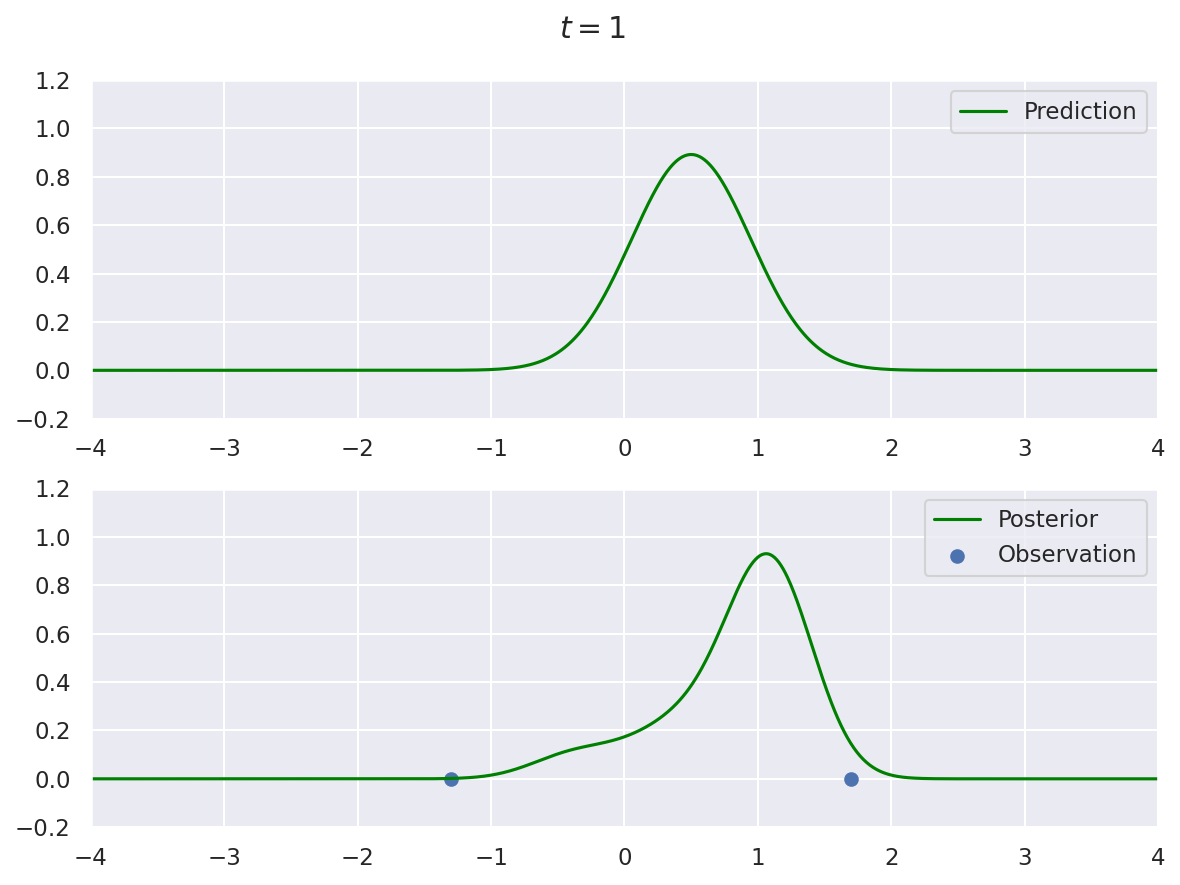

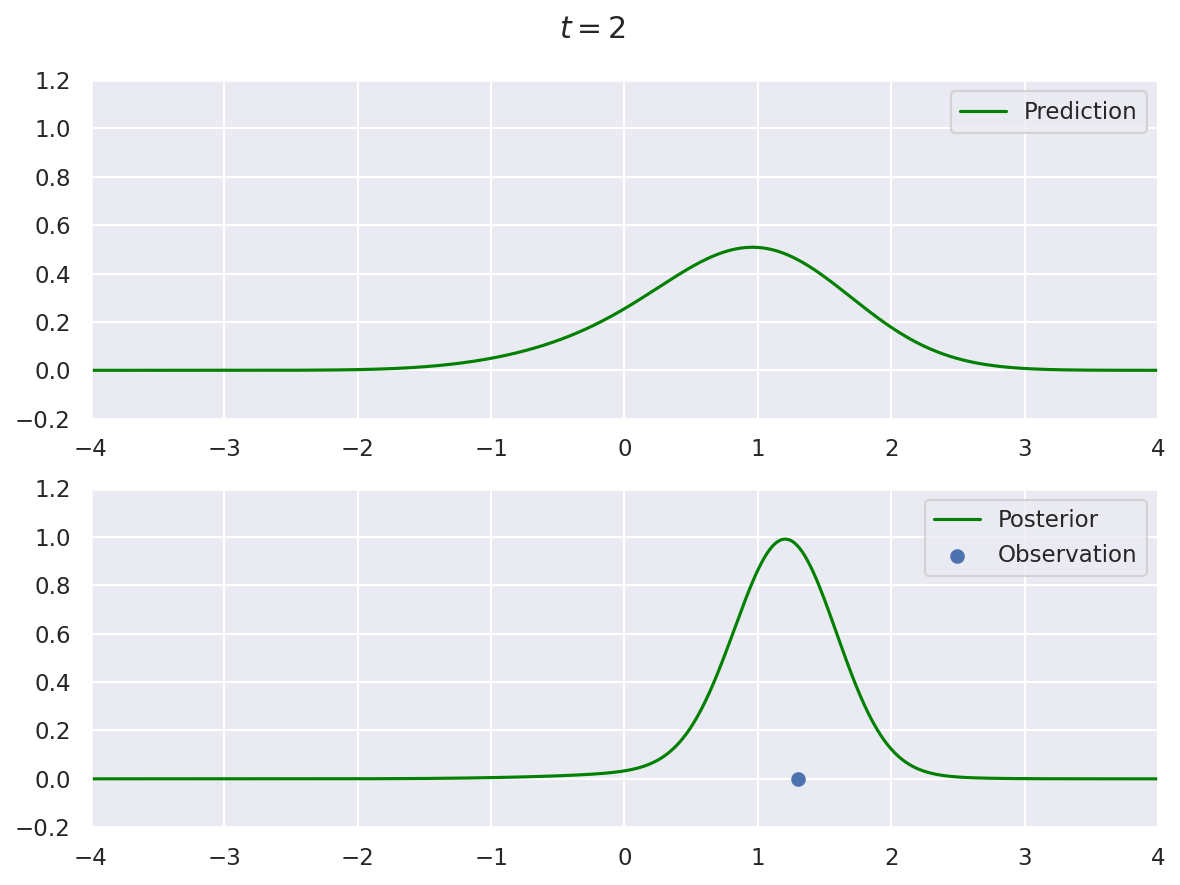

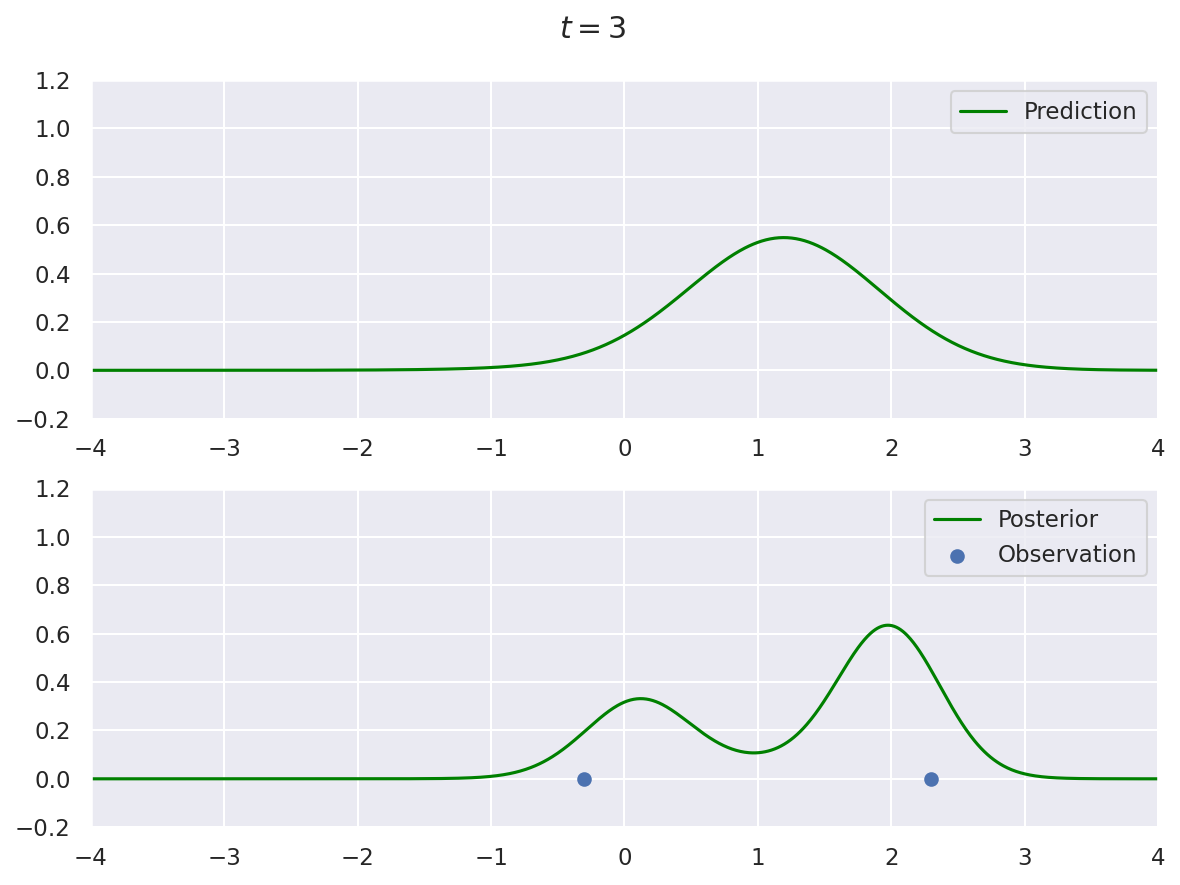

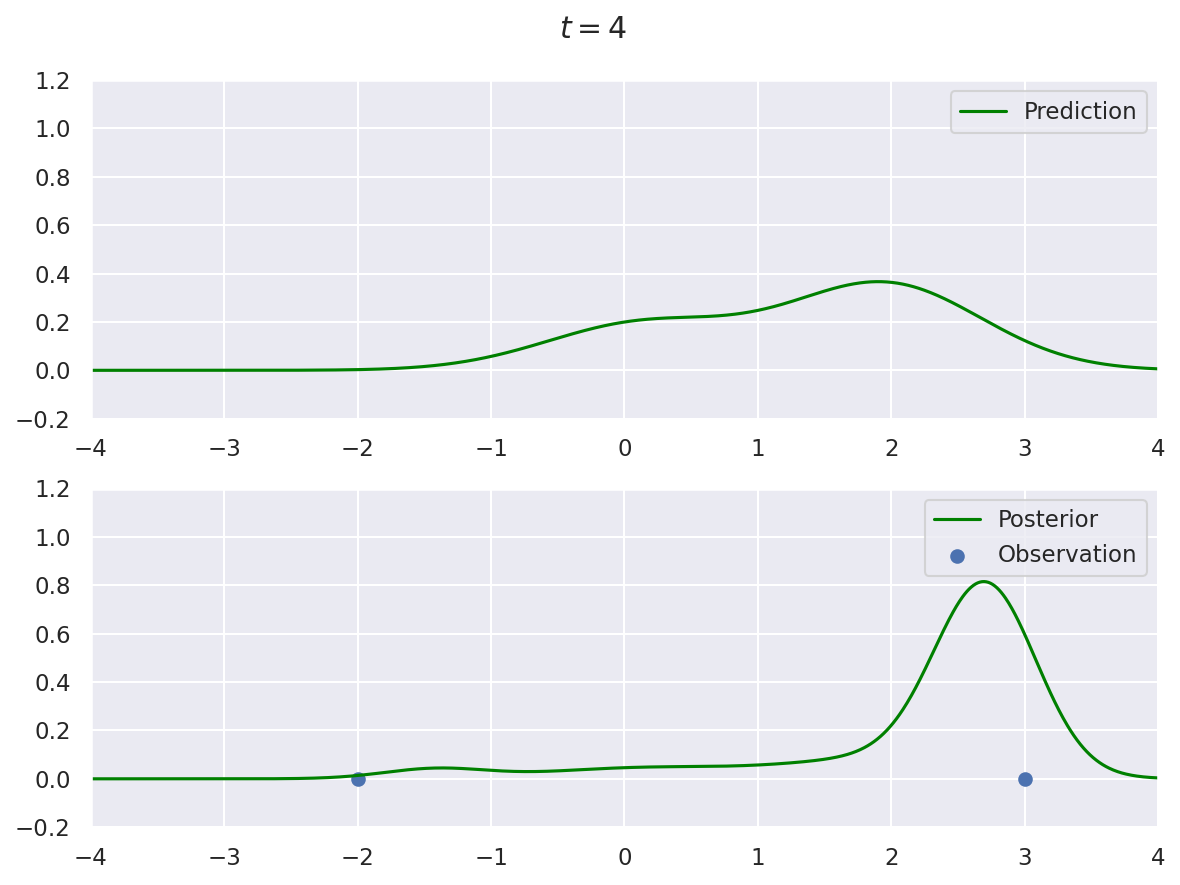

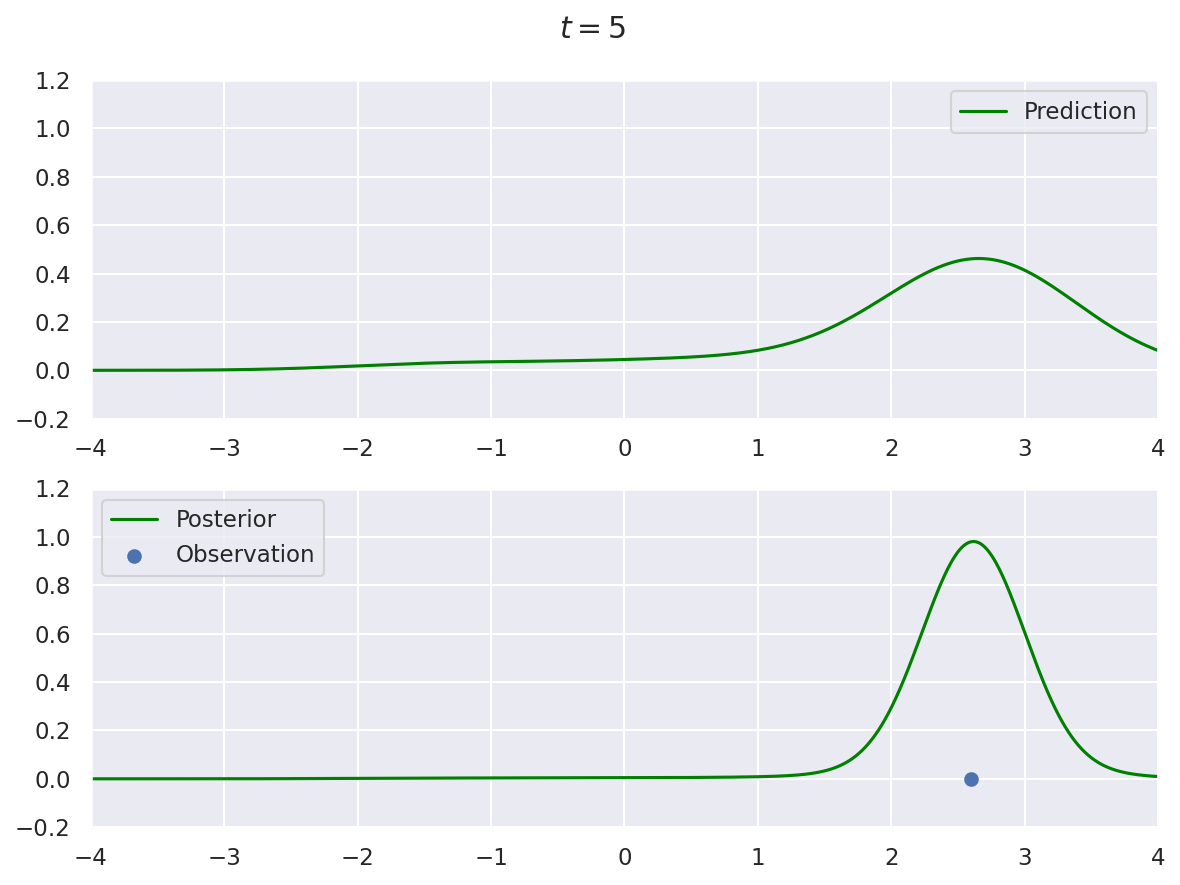

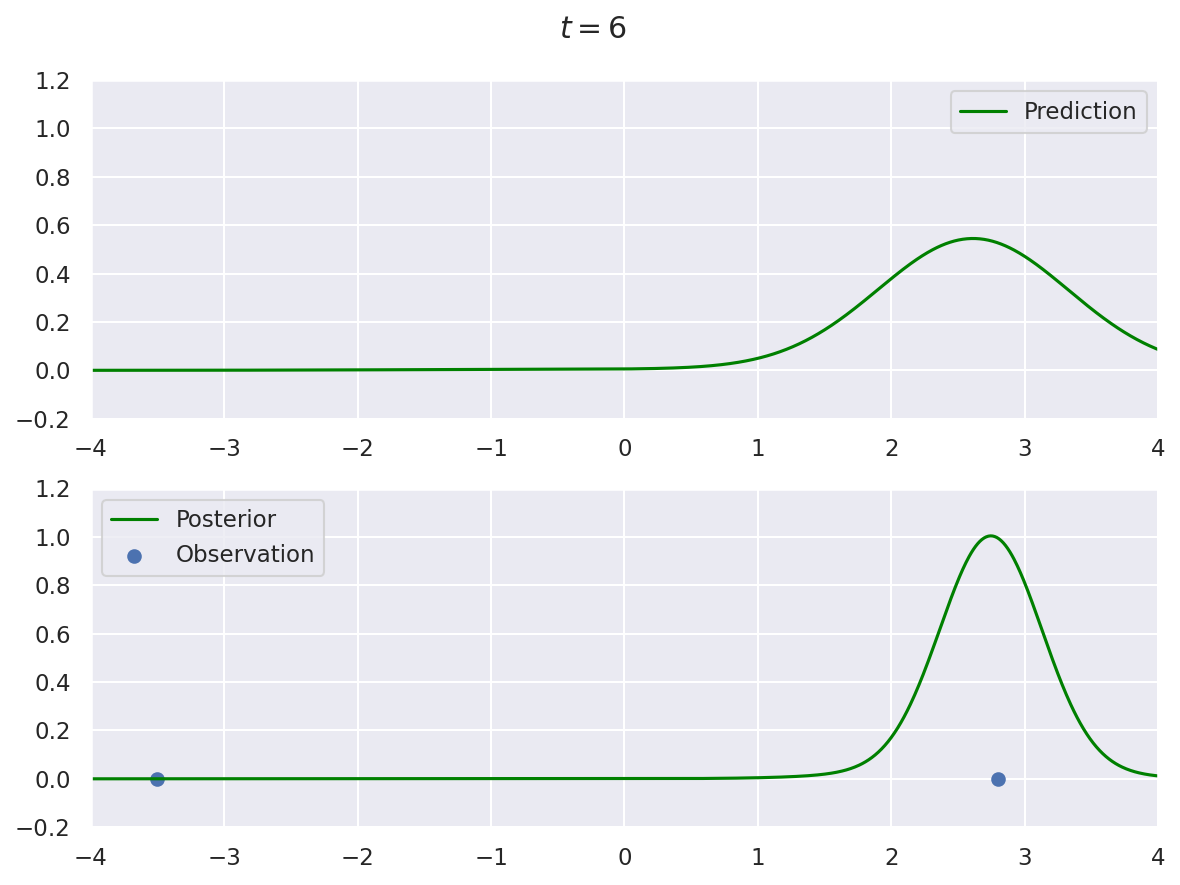

In [5]:
def plot_1d_gaussian(mean, var, w, ax, x_lim, **kwargs):
    x = np.linspace(*x_lim, 1000)
    y = w * multivariate_normal.pdf(x, mean=mean, cov=var)
    ax.plot(x, y, **kwargs)

def plot_1d_mixture_gaussian(means, vars, ws, ax, x_lim, **kwargs):
    x = np.linspace(*x_lim, 1000)
    y = np.zeros_like(x)
    for mean, var, w in zip(means, vars, ws):
        y += w * multivariate_normal.pdf(x, mean=mean, cov=var)
    ax.plot(x, y, **kwargs)

for t in range(1, T+1):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=150)

    xlim = (-4, 4)

    # for x, P, w in zip(x_preds[t], P_preds[t], w_upds[t-1]):
        # plot_1d_gaussian(x[0], P[0][0], w, ax[0], (-3, 3), color='red', linestyle='dashed')
    # if t > 1:
        # plot_1d_mixture_gaussian(x_upds[t-1], P_upds[t-1], w_upds[t-1], ax[0], (-3, 3), color='red', linestyle='dashed')
    plot_1d_mixture_gaussian(x_preds[t], P_preds[t], w_upds[t-1], ax[0], xlim, color='green', linestyle='solid', label='Prediction')

    # for x_upd, P_upd, w_upd in zip(x_upds[t], P_upds[t], w_upds[t]):
    #     plot_1d_gaussian(x_upd[0], P_upd[0][0], w_upd, ax[1], (-3, 3), color='red', linestyle='dashed')
    plot_1d_mixture_gaussian(x_upds[t], P_upds[t], w_upds[t], ax[1], xlim, color='green', linestyle='solid', label='Posterior')

    ax[1].scatter(z_obs[t-1], np.zeros(len(z_obs[t-1])), label='Observation')

    ax[0].set_xlim(xlim)
    ax[0].set_ylim((-0.2, 1.2))
    # ax[0].set_aspect('equal')
    # ax[0].set_title(f'Prediction at $t={t}$')
    ax[0].legend()

    ax[1].set_xlim(xlim)
    ax[1].set_ylim((-0.2, 1.2))
    # ax[1].set_aspect('equal')
    # ax[1].set_title(f'Update at $t={t}$')
    ax[1].legend()

    fig.suptitle(f'$t={t}$')
    plt.tight_layout()
    plt.show()


In [9]:
# Initial
x0 = np.array([0.5])
P0 = np.array([[0.2]])

# Observations
z_obs = [
    [np.array([-1.3]), np.array([1.7])],
    [np.array([ 1.3])],
    [np.array([-0.3]), np.array([2.3])],
    [np.array([-0.7]), np.array([3.0])],
    [np.array([-1.0])],
    [np.array([-1.3])]
]
T = len(z_obs)
u_obs = np.zeros((T, 1))

x_preds, P_preds, x_upds, P_upds, w_upds, traces = sot.filter(z_obs, u_obs, x0, P0)

[-0.4]
[1.1]
[1.08666667]
[0.77692308]
[1.23846154]
[-0.15454545]
[1.97272727]
[0.09808612]
[1.95167464]
[-0.32]
[1.76]
[0.01284916]
[1.8575419]
[-0.02]
[2.06]
[0.14692737]
[1.99162011]
[-0.53448276]
[2.65517241]
[-0.54713376]
[2.11592357]
[0.04904459]
[2.71210191]
[-0.35859873]
[2.6343949]
[-0.46953368]
[2.16200345]
[0.06573402]
[2.69727116]
[-0.65555556]
[2.4962963]
[-0.59295775]
[2.06478873]
[-0.00704225]
[2.65070423]
[-0.41555556]
[2.57185185]
[-0.49394429]
[2.13653613]
[0.03928139]
[2.66976181]
[-0.43333333]
[2.71851852]
[-0.5084507]
[2.14929577]
[0.07746479]
[2.73521127]
[-0.32666667]
[2.66074074]
[-0.45518773]
[2.17529269]
[0.07803795]
[2.70851837]
[-0.83333333]
[-0.87112172]
[0.01193317]
[-0.84102564]
[-0.86948141]
[-0.10197338]
[-0.44102564]
[-0.69765948]
[0.06984855]
[-0.70119332]
[-0.81977629]
[0.02120805]
[-0.78935291]
[-0.84674035]
[-0.08644994]
[-0.43377696]
[-0.69209351]
[0.0681969]
[-0.92941176]
[-0.90437018]
[-0.02930591]
[-0.87169811]
[-0.88263959]
[-0.11634518]
[-0.4

In [ ]:
def plot_1d_gaussian(mean, var, w, ax, x_lim, **kwargs):
    x = np.linspace(*x_lim, 1000)
    y = w * multivariate_normal.pdf(x, mean=mean, cov=var)
    ax.plot(x, y, **kwargs)

def plot_1d_mixture_gaussian(means, vars, ws, ax, x_lim, **kwargs):
    x = np.linspace(*x_lim, 1000)
    y = np.zeros_like(x)
    for mean, var, w in zip(means, vars, ws):
        y += w * multivariate_normal.pdf(x, mean=mean, cov=var)
    ax.plot(x, y, **kwargs)

for t in range(1, T+1):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), dpi=150)

    xlim = (-4, 4)

    # for x, P, w in zip(x_preds[t], P_preds[t], w_upds[t-1]):
        # plot_1d_gaussian(x[0], P[0][0], w, ax[0], (-3, 3), color='red', linestyle='dashed')
    # if t > 1:
        # plot_1d_mixture_gaussian(x_upds[t-1], P_upds[t-1], w_upds[t-1], ax[0], (-3, 3), color='red', linestyle='dashed')
    plot_1d_mixture_gaussian(x_preds[t], P_preds[t], w_upds[t-1], ax[0], xlim, color='green', linestyle='solid', label='Prediction')

    # for x_upd, P_upd, w_upd in zip(x_upds[t], P_upds[t], w_upds[t]):
    #     plot_1d_gaussian(x_upd[0], P_upd[0][0], w_upd, ax[1], (-3, 3), color='red', linestyle='dashed')
    plot_1d_mixture_gaussian(x_upds[t], P_upds[t], w_upds[t], ax[1], xlim, color='green', linestyle='solid', label='Posterior')

    ax[1].scatter(z_obs[t-1], np.zeros(len(z_obs[t-1])), label='Observation')

    ax[0].set_xlim(xlim)
    ax[0].set_ylim((-0.2, 1.2))
    # ax[0].set_aspect('equal')
    # ax[0].set_title(f'Prediction at $t={t}$')
    ax[0].legend()

    ax[1].set_xlim(xlim)
    ax[1].set_ylim((-0.2, 1.2))
    # ax[1].set_aspect('equal')
    # ax[1].set_title(f'Update at $t={t}$')
    ax[1].legend()

    fig.suptitle(f'$t={t}$')
    plt.tight_layout()
    plt.show()
